In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Twitter_Data.csv to Twitter_Data.csv


In [ ]:
twitter = pd.read_csv('Twitter_Data.csv')

In [ ]:
twitter.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
print("Shape of the dataset:", twitter.shape)

Shape of the dataset: (162980, 2)


In [ ]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
print(twitter['category'].value_counts())

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64


In [ ]:
print(twitter.isnull().sum())

clean_text    4
category      7
dtype: int64


In [ ]:
twitter = twitter.dropna()
print(twitter.isnull().sum())

clean_text    0
category      0
dtype: int64


In [ ]:
duplicates = twitter.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


#**Data Preprocessing**

In [ ]:
import re

def clean_tweet(tweet):
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)  # Remove URLs
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Remove special characters
    tweet = tweet.lower()  # Convert to lowercase
    return tweet

twitter['clean_text'] = twitter['clean_text'].apply(clean_tweet)

In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import word_tokenize

twitter['tokens'] = twitter['clean_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk

nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
twitter['tokens'] = twitter['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...


#**Sentiment Analysis**

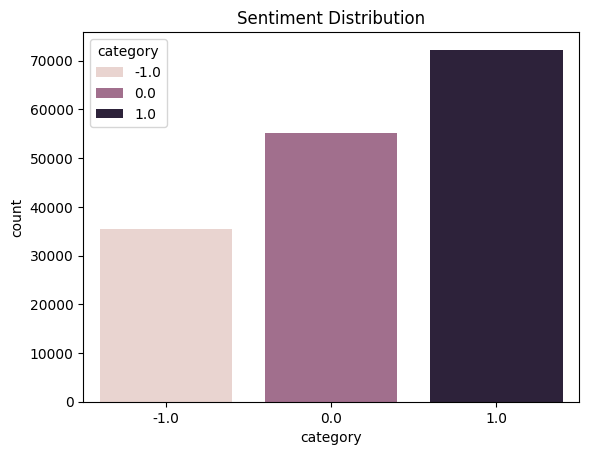

In [ ]:
sns.countplot(data=twitter, x='category', hue='category')
plt.title('Sentiment Distribution')
plt.show()

The figure shows that a positive sentiment (1) is dominant.

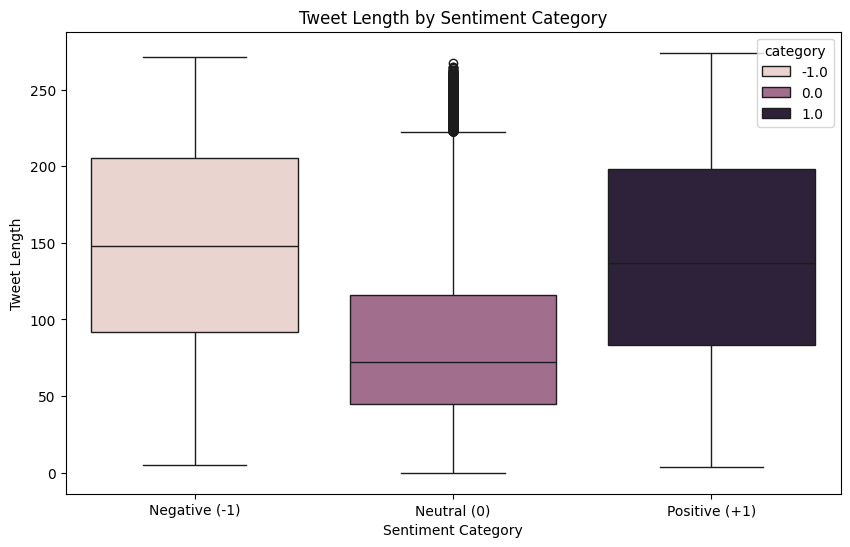

In [ ]:
# Creating new column for tweet length
twitter['tweet_length'] = twitter['clean_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(data=twitter, x='category', y='tweet_length', hue='category')
plt.title('Tweet Length by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Tweet Length')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (+1)'])
plt.show()

The analysis indicates that the length of tweets is related to the sentiment expressed, with positive tweets tending to be longer than neutral or negative tweets. The wider range of tweet lengths for the negative and positive categories indicates more variability in how users express those sentiments compared to the more compact distribution for neutral tweets.

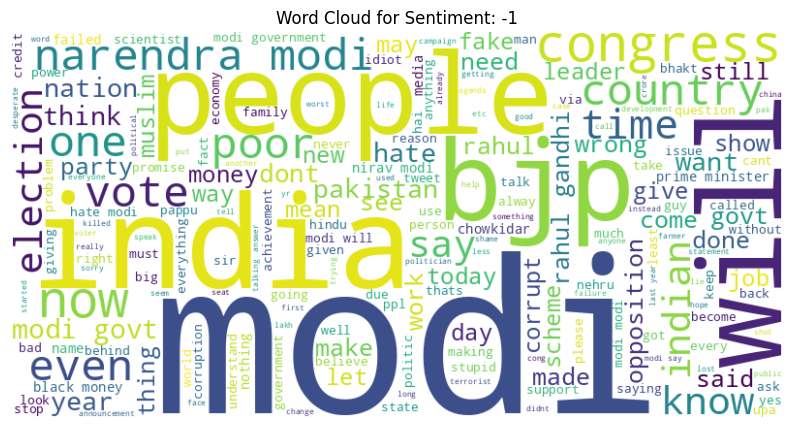

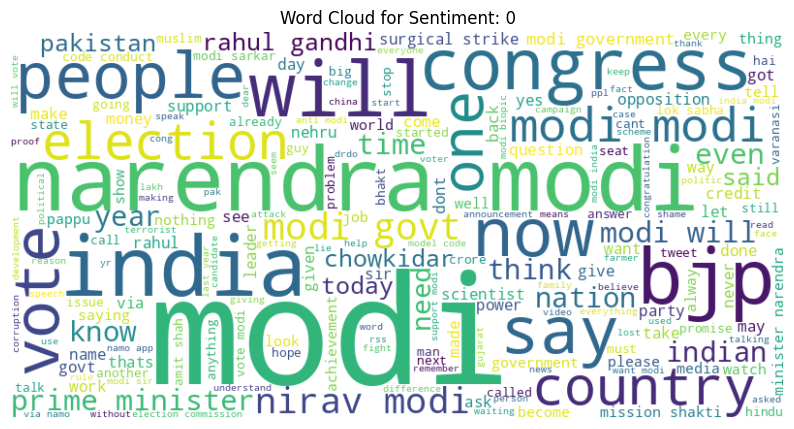

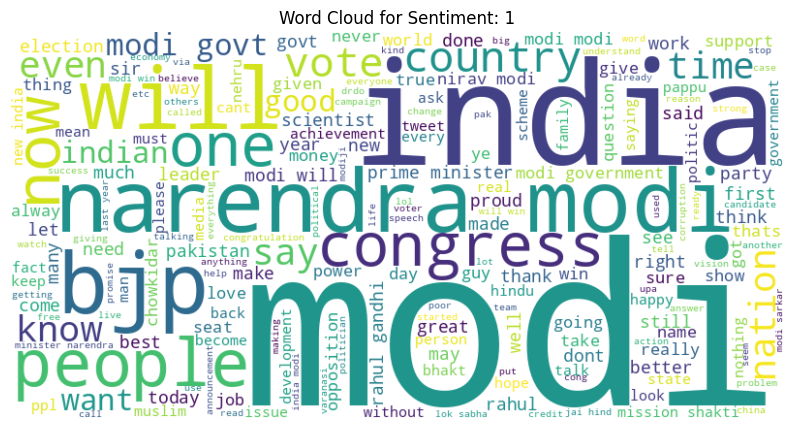

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud


#generate word cloud
def plot_wordcloud(sentiment):
    text = ' '.join(twitter[twitter['category'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Sentiment: {sentiment}')
    plt.show()

# word clouds for each sentiment
plot_wordcloud(-1)  # Negative
plot_wordcloud(0)   # Neutral
plot_wordcloud(1)   # Positive

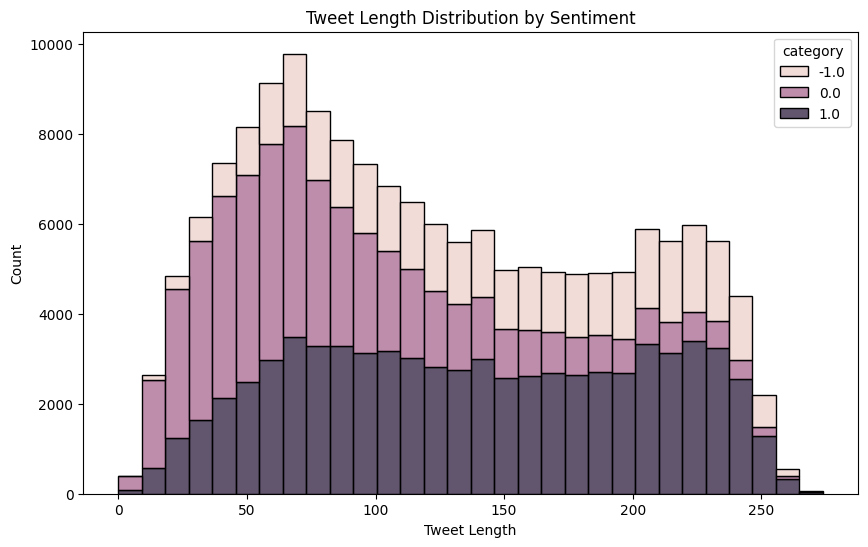

In [ ]:
#tweet lengths distribution by sentiment
plt.figure(figsize=(10, 6))
sns.histplot(twitter, x='tweet_length', hue='category', multiple='stack', bins=30)
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

This figure similarly to the above figure suggests that there is a relationship between the sentiment expressed in a tweet and its length, with negative and positive tweets tending to have a wider range of lengths compared to neutral tweets.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(twitter['clean_text'])

feature_names = tfidf.get_feature_names_out()

# Extracting the top 10 words for each sentiment
for sentiment in twitter['category'].unique():
    print(f"Top 10 words for sentiment {sentiment}:")
    sentiment_index = twitter['category'] == sentiment
    sentiment_tfidf = X[sentiment_index].sum(axis=0).A1
    top_words = [feature_names[i] for i in np.argsort(sentiment_tfidf)[-10:]]
    print(', '.join(top_words))
    print()

Top 10 words for sentiment -1.0:
will, this, that, are, not, you, for, and, modi, the

Top 10 words for sentiment 0.0:
narendra, india, this, not, will, you, and, for, the, modi

Top 10 words for sentiment 1.0:
that, this, are, will, india, you, for, and, modi, the



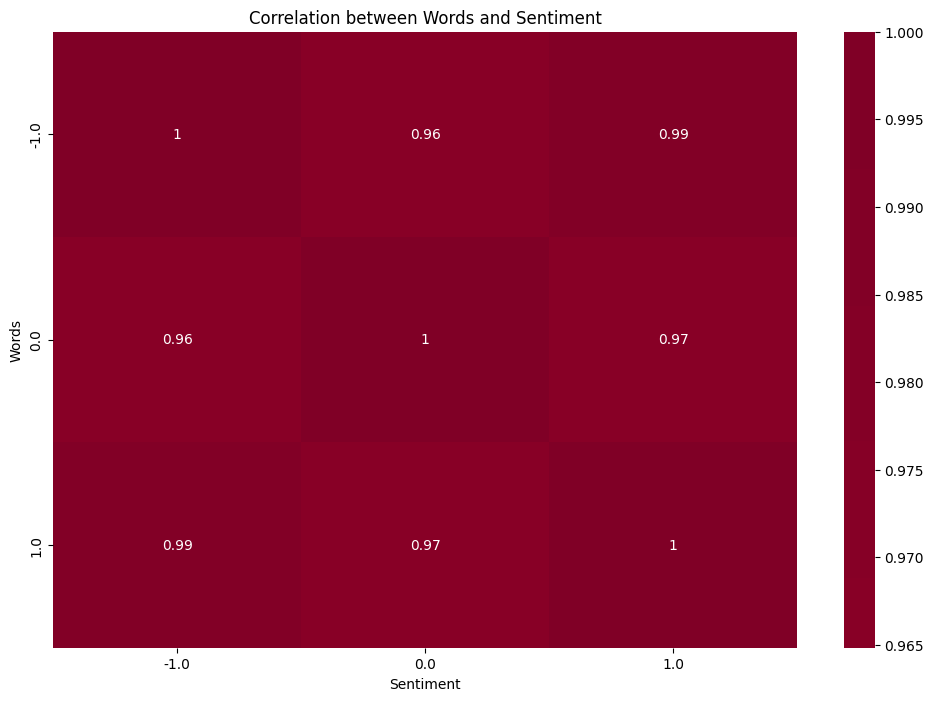

In [ ]:
#  word-sentiment correlation matrix
word_sentiment_corr = twitter.groupby('category')['clean_text'].apply(lambda x: x.str.split().explode().value_counts()).unstack(fill_value=0)
word_sentiment_corr = word_sentiment_corr.T.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(word_sentiment_corr, cmap='YlOrRd', center=0, annot=True)
plt.title('Correlation between Words and Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Words')
plt.show()

The above heatmap indicates that there is a strong positive correlation between words and sentiments with each sentiment having a strong association with their corresponding words.

#**Feature Engineering and Feature Selection**

In [ ]:
# Check for NaN values in the 'clean_text' column
nan_count = twitter['clean_text'].isnull().sum()
print(f"Number of NaN values in 'clean_text': {nan_count}")

Number of NaN values in 'clean_text': 4


In [ ]:
twitter = twitter.dropna(subset=['clean_text', 'category'])
print(f"Number of NaN values after dropping: {twitter['clean_text'].isnull().sum()}")

Number of NaN values after dropping: 0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(twitter['clean_text'])
print(f"Shape of TF-IDF features: {X_tfidf.shape}")

Shape of TF-IDF features: (162969, 1000)


In [ ]:
# Create random sentiment embeddings
embedding_dim = 3
sentiment_emb = np.random.rand(len(tfidf.vocabulary_), embedding_dim)

In [ ]:
document_sentiment_emb = np.zeros((len(twitter), 3))

for i, text in enumerate(twitter['clean_text']):
    word_embeddings = [sentiment_emb[tfidf.vocabulary_[word]] for word in text.split() if word in tfidf.vocabulary_]
    if word_embeddings:
        document_sentiment_emb[i] = np.mean(word_embeddings, axis=0)
X_combined = np.hstack((X_tfidf.toarray(), document_sentiment_emb))

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
y = twitter['category']
k = min(500, X_combined.shape[1])
selector = SelectKBest(chi2, k=k)
X_selected = selector.fit_transform(X_combined, y)
print(f"Shape of selected features: {X_selected.shape}")

Shape of selected features: (162969, 500)


#**Model Training**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
X = twitter['clean_text']  # Features (text data)
y = twitter['category']     # Target variable (sentiments)

# Spliting the data into test-train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**1. Naive bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
tfidf = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#train model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

#make predictions
y_pred = model.predict(X_test_tfidf)

#Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6648
              precision    recall  f1-score   support

        -1.0       0.89      0.27      0.41      7152
         0.0       0.69      0.66      0.67     11067
         1.0       0.63      0.87      0.73     14375

    accuracy                           0.66     32594
   macro avg       0.74      0.60      0.60     32594
weighted avg       0.71      0.66      0.64     32594



The accuracy of 66.48% suggests that while the model is somewhat effective, there is room for improvement, especially in precision and recall for class -1.0.

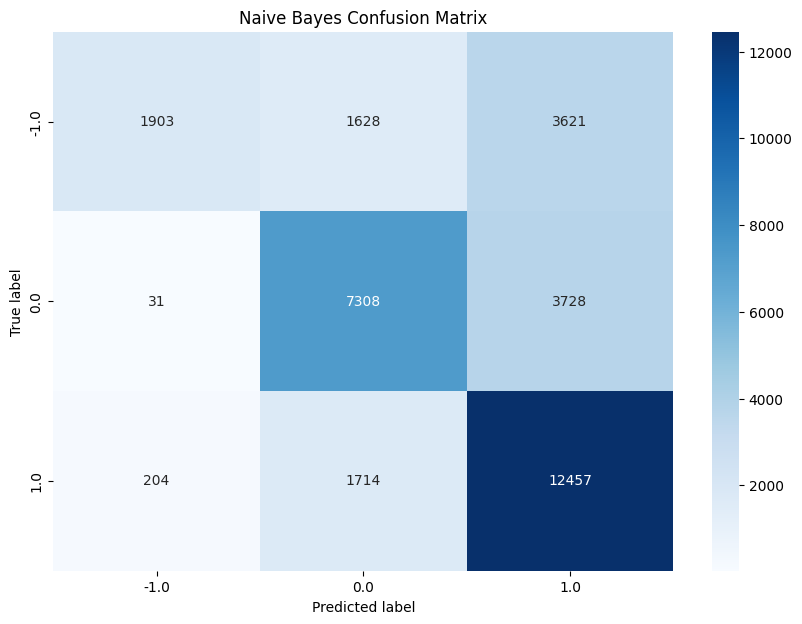

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)

cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()





The Naive Bayes model seems to have better precision on the negative and positive classes, but lower recall on the negative class. This suggests the model may be biased towards the positive class.

**2.Deep Learning**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

X = twitter['clean_text']
y = twitter['category']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# Build Model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))  # Input layer
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dropout(0.5))  # Dropout layer
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Output layer

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_test_tfidf, y_test))

#predictions
y_pred = model.predict(X_test_tfidf)
y_pred_classes = np.argmax(y_pred, axis=1)

#Evaluating the model
accuracy = np.mean(y_pred_classes == y_test)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_classes))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.6602 - loss: 0.7800 - val_accuracy: 0.7656 - val_loss: 0.6134
Epoch 2/10
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7635 - loss: 0.6179 - val_accuracy: 0.7652 - val_loss: 0.6050
Epoch 3/10
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7710 - loss: 0.5983 - val_accuracy: 0.7679 - val_loss: 0.6002
Epoch 4/10
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7745 - loss: 0.5910 - val_accuracy: 0.7693 - val_loss: 0.5973
Epoch 5/10
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7744 - loss: 0.5837 - val_accuracy: 0.7693 - val_loss: 0.5976
Epoch 6/10
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7793 - loss: 0.5745 - val_accuracy: 0.7701 - val_loss: 0.5974
Epoch 7/10
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7792 - loss: 0.5701 - val_accuracy: 0.7698 - val_loss: 0.5968
Epoch 8/10
4075/4075 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7825 - loss: 0

The accuracy of 77.05% is a good result and indicates that the deep learning model is performing well.


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


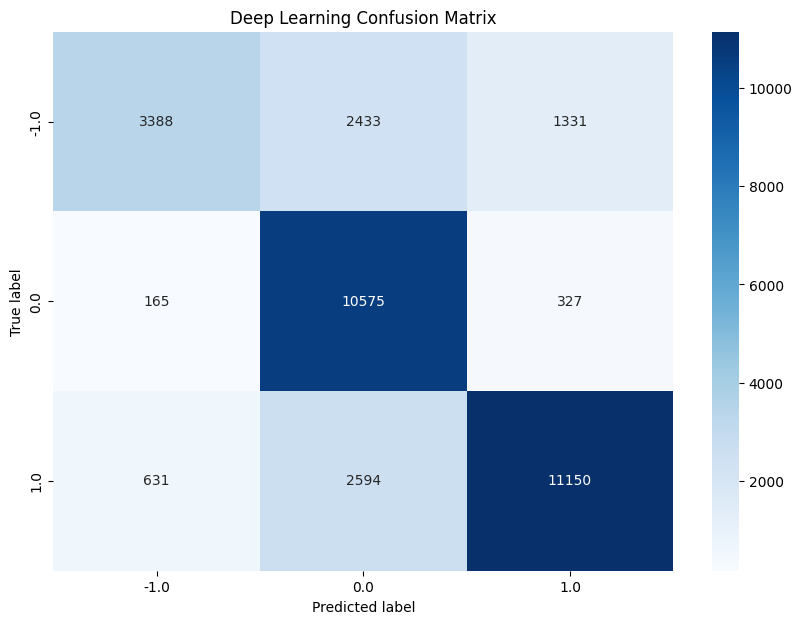

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

y_pred_dl = model.predict(X_test_tfidf)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)

cm_dl = confusion_matrix(y_test, y_pred_dl_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Deep Learning Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



 The deep learning model shows a stronger performance with a high precision and recall for the positive and neutral classes, but could still be improved in handling the negative class.



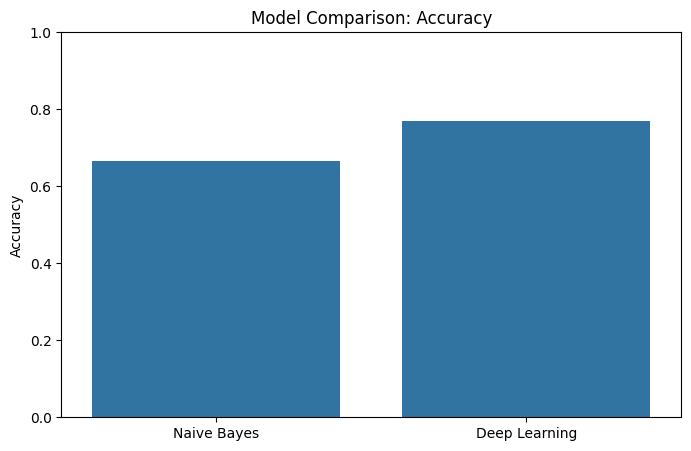

In [ ]:
models = ['Naive Bayes', 'Deep Learning']
accuracy = [0.6648, 0.7705]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracy,)
plt.title('Model Comparison: Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

The Deep Learning model has a  higher accuracy of around 0.77 (or 77%) compared to the Naive Bayes model which has an accuracy of around 0.66 (or 66%).
This indicates that the Deep Learning model performs better than the Naive Bayes model in terms of overall classification accuracy.